# Assignment 8 — Logistic Regression



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

pd.set_option("display.max_columns", 200)


In [2]:
df = pd.read_csv(r"/content/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Basic structure
print("Shape:", df.shape)
df.info()
df.describe().T


Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:

print("NaNs per column:\n", df.isna().sum())


possible_zero_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
present = [col for col in possible_zero_missing if col in df.columns]
print("\nColumns where 0 may indicate missing:", present)

if present:
    for col in present:
        zero_ct = (df[col] == 0).sum()
        print(f"  {col}: zeros = {zero_ct} ({zero_ct/len(df):.1%})")


NaNs per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Columns where 0 may indicate missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
  Glucose: zeros = 5 (0.7%)
  BloodPressure: zeros = 35 (4.6%)
  SkinThickness: zeros = 227 (29.6%)
  Insulin: zeros = 374 (48.7%)
  BMI: zeros = 11 (1.4%)


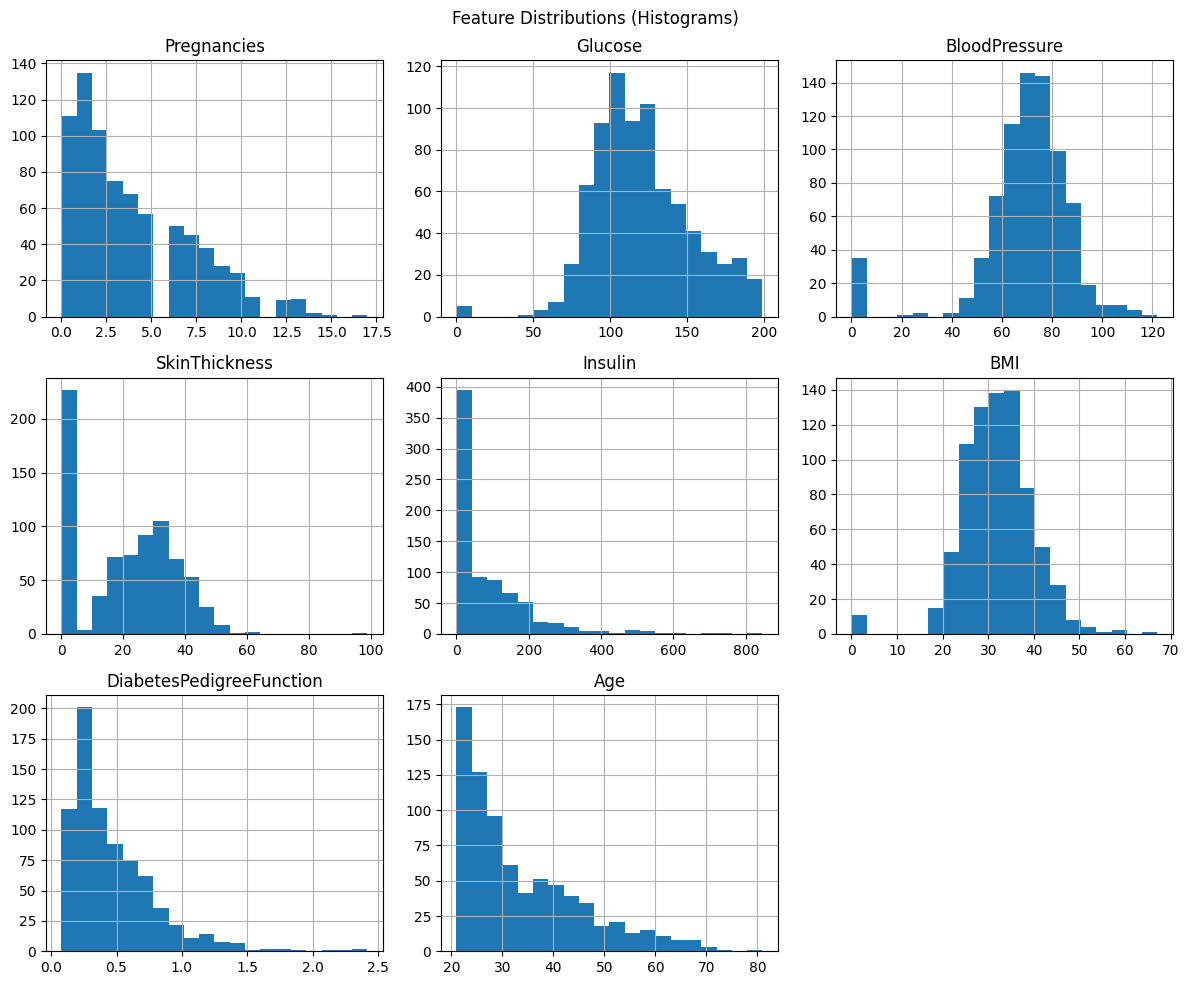

<Figure size 1200x600 with 0 Axes>

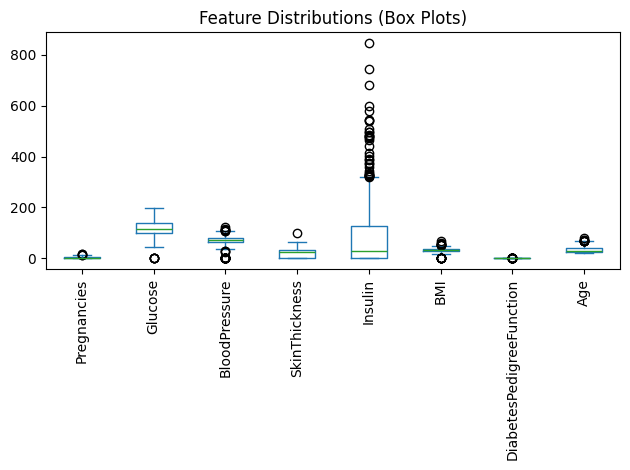

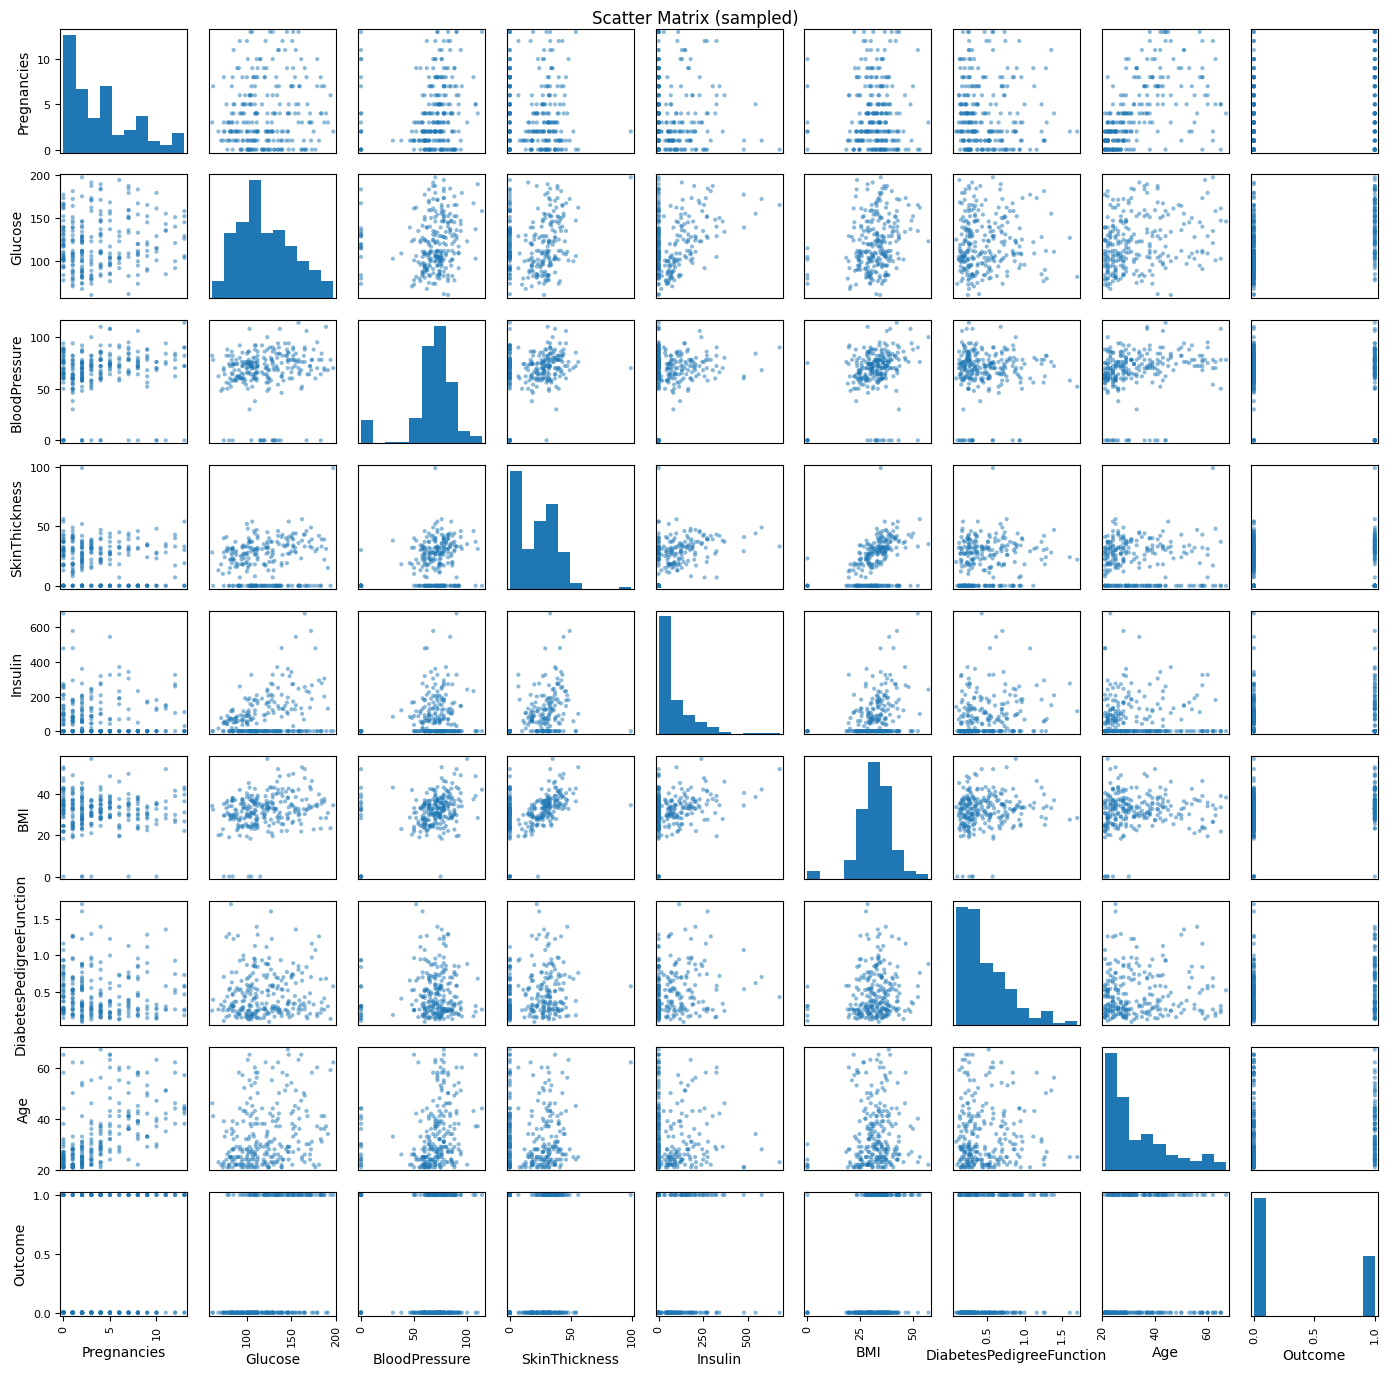

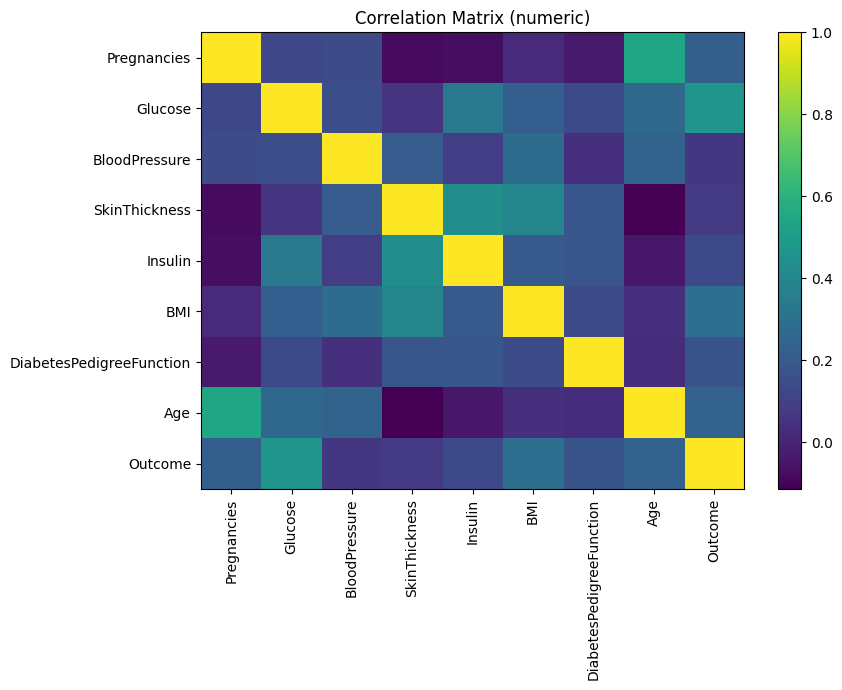


Correlation with target:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [5]:

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
target_col = 'Outcome'

feature_cols = [c for c in numeric_cols if c != target_col]

# Histograms
df[feature_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle("Feature Distributions (Histograms)")
plt.tight_layout()
plt.show()

# Boxplots (helps see outliers)
plt.figure(figsize=(12, 6))
df[feature_cols].plot(kind="box", rot=90)
plt.title("Feature Distributions (Box Plots)")
plt.tight_layout()
plt.show()

# Scatter matrix
from pandas.plotting import scatter_matrix
sample_df = df[feature_cols + [target_col]].sample(min(250, len(df)), random_state=42)
scatter_matrix(sample_df, figsize=(14, 14), diagonal="hist")
plt.suptitle("Scatter Matrix (sampled)")
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(9, 7))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (numeric)")
plt.colorbar()
plt.tight_layout()
plt.show()


if df[target_col].nunique() == 2 and pd.api.types.is_numeric_dtype(df[target_col]):
    print("\nCorrelation with target:")
    print(corr[target_col].sort_values(ascending=False))


## 2) Data Preprocessing

In [6]:

target_col = 'Outcome'
X = df.drop(columns=[target_col])
y = df[target_col]


num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

zero_missing_cols = [c for c in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"] if c in X.columns]
X = X.copy()
for c in zero_missing_cols:
    X.loc[X[c] == 0, c] = np.nan


numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Train shape: (614, 8)  Test shape: (154, 8)
Numeric cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical cols: []


## 3) Model Building

In [7]:

log_reg = LogisticRegression(max_iter=2000)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", log_reg)
])

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


## 4) Model Evaluation

Accuracy : 0.7078
Precision: 0.6000
Recall   : 0.5000
F1-score : 0.5455
ROC-AUC  : 0.8130

Confusion Matrix:
 [[82 18]
 [27 27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



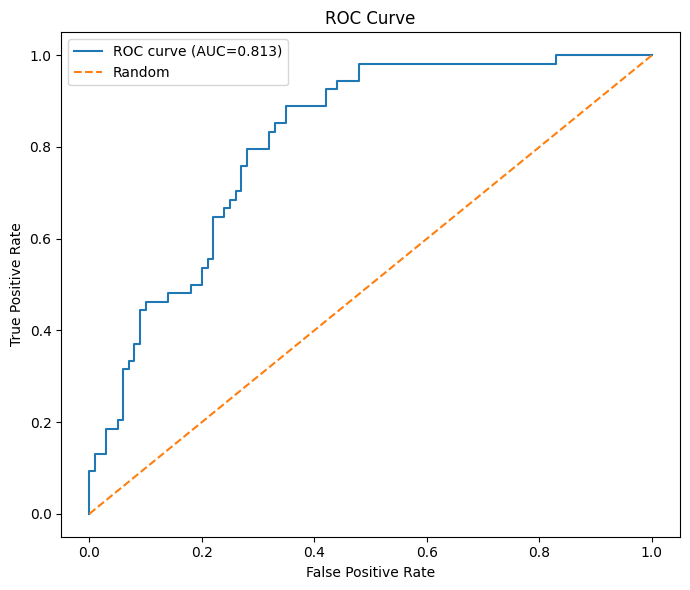

In [8]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}\n")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


## 5) Interpretation

In [9]:

pre = model.named_steps["preprocess"]

feature_names = []


num_features = pre.transformers_[0][2]
feature_names.extend(num_features)


cat_features = pre.transformers_[1][2]
if len(cat_features) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_features).tolist()
    feature_names.extend(ohe_names)

clf = model.named_steps["classifier"]
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio_exp_coef": np.exp(coefs)
}).sort_values("coef", ascending=False)

coef_df.head(15)


,feature,coef,odds_ratio_exp_coef
1,Glucose,1.182567,3.262739
5,BMI,0.688652,1.991030
0,Pregnancies,0.377446,1.458554
6,DiabetesPedigreeFunction,0.233337,1.262807
7,Age,0.147794,1.159274
3,SkinThickness,0.028321,1.028725
2,BloodPressure,-0.044111,0.956848
4,Insulin,-0.066119,0.936019


### How to read coefficients
- **Positive coefficient** → increases the log-odds of the positive class (class = 1).
- **Negative coefficient** → decreases the log-odds.
- **Odds ratio** = `exp(coef)`
  - `> 1` means higher odds of class 1 as the feature increases
  - `< 1` means lower odds

Focus on features with the **largest absolute coefficients** (after scaling) for impact.
